# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from relaxed.analysis import draw_histogram, get_quantiles, gaussian_conditional, \
get_bins, setup, get_am, get_a2_from_am, get_lam

# Data

In [25]:
# catalog
hcat, indices, scales = setup('m11', path='../../output')
cvir = hcat.cat['cvir']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../output')
a2 = get_a2_from_am(am, mass_bins)

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape, mass_bins.shape, a2.shape, cvir.shape)

(9999, 98) (98,) (9999,) (9999,)


In [26]:
 # remove nan's from lam along the way, like ~600 haloes.
keep, lam, cvir, a2 = get_lam(am, cvir, a2)
am = am[keep]
print(sum(keep), lam.shape, cvir.shape, a2.shape, am.shape)

9449 (9449, 98) (9449,) (9449,) (9449, 98)


In [27]:
# train/test split.
lam_train, lam_test, cvir_train, cvir_test, a2_train, a2_test = train_test_split(lam, cvir, a2, test_size=0.33)
print(cvir_train.shape)
print(cvir_test.shape)

(6330,)
(3119,)


# Train

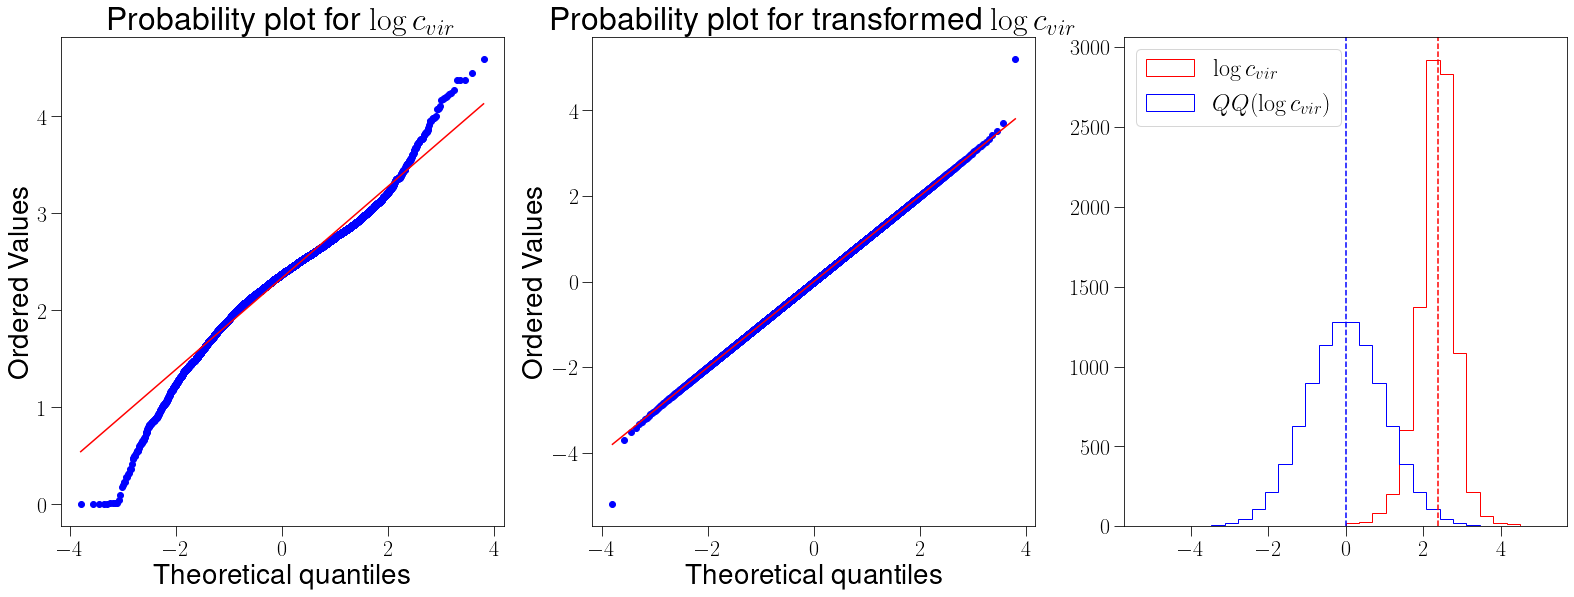

In [75]:
# multivariate prediction
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
def gauss(lam_test):
    return np.exp(mu_cond(lam_test))

# lognormal samples 
mu, sigma = np.mean(np.log(cvir_train)), np.std(np.log(cvir_train))
def lognormal(lam_test): 
    n_test = len(lam_test)
    log_cvir_pred = np.random.normal(mu, sigma, n_test)
    return np.exp(log_cvir_pred)


# rank approach
from scipy.interpolate import interp1d
cvir_sort, a2_sort = np.sort(-cvir_train), np.sort(a2_train)
cvir_sort = -cvir_sort
marks = np.arange(len(cvir_sort)) / len(cvir_sort)
marks += (marks[1] - marks[0]) / 2
a2_to_mark = interp1d(a2_sort, marks, fill_value=(0, 1), bounds_error=False)
mark_to_cvir = interp1d(marks, cvir_sort, fill_value=(cvir_sort[0], cvir_sort[-1]), bounds_error=False)

def cam(lam_test):
    _a2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
    assert np.all(_a2_test == a2_test)
    return mark_to_cvir(a2_to_mark(_a2_test))

# multi-normal but just using a_{1/2}

# linear regression 
from sklearn.linear_model import LinearRegression # requires shape (n_samples, n_features)
from scipy import stats
reg = LinearRegression().fit(lam_train, np.log(cvir_train))

def linreg(lam_test):
    return np.exp(reg.predict(lam_test))



# Arya's method 

# gaussian remapping
from sklearn.preprocessing import QuantileTransformer
# rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=len(cvir), output_distribution='normal')
lcvir_trans = qt.fit(np.log(cvir.reshape(-1, 1))).transform(np.log(cvir).reshape(-1, 1))
fig, axes = plt.subplots(1, 3, figsize=(27, 9))
ax1, ax2, ax3 = axes.flatten()
res = stats.probplot(np.log(cvir).reshape(-1), dist='norm', plot=ax1)
res = stats.probplot(lcvir_trans.reshape(-1), dist='norm', plot=ax2)
ax1.set_title(r"Probability plot for $\log c_{vir}$")
ax2.set_title(r"Probability plot for transformed $\log c_{vir}$")

bins = get_bins(lcvir_trans, bins=30)
draw_histogram(ax3, np.log(cvir), bins=bins, color='r', label=r'$\log c_{vir}$')
draw_histogram(ax3, lcvir_trans, bins=bins, color='b', label=r'$QQ(\log c_{vir})$')

ax3.legend(loc=0)


# Plots

## Combined histogram of residuals

In [29]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = None
    correlations = []
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        x = (X_pred - X_test) / X_test
        if bins is None: 
            bins = get_bins(x, range=(-1, 3)) # share bins between all histograms.
        draw_histogram(ax, x, vline=None, label=labels[i], color=colors[i], 
                       bins=bins, density=False)
        
        print(f'{labels[i]} corr: {scipy.stats.spearmanr(X_pred, X_test)[0]}')
        
    ax.axvline(0, color='k', ls='--')
    ax.legend()
    ax.set_ylabel(r"\rm Counts", size=28)
    ax.set_xlabel(r"$(c^{\rm pred}_{\rm vir} - c^{\rm test}_{\rm vir}) / c^{\rm test}_{\rm vir}$", size=28)

MG-FC corr: 0.7676990082272511
LN-RS corr: 0.0032733149131327407
CAM corr: 0.7017261491701584
MV-LR corr: 0.7676990082272511


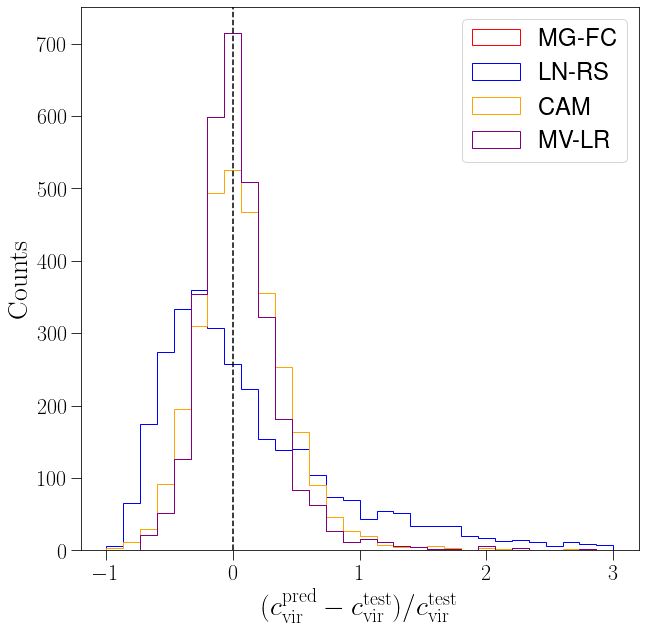

In [30]:
labels = ['MG-FC', 'LN-RS', 'CAM', 'MV-LR']
colors = ['r', 'b', 'orange', 'purple']
combined_histogram(lam_test, cvir_test, gauss, lognormal, cam, linreg, labels=labels, colors=colors)

## Scatter plots of residuals

In [12]:
def scatter_plots(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3'), alpha=0.5): 
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        ax1.scatter(X_test, x, alpha=alpha, color=colors[i], label=labels[i])
        ax1.set_xlabel(r"$c^{\rm true}_{\rm vir}$")
        ax1.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")
        
        
        ax2.scatter(X_pred, x, alpha=alpha, color=colors[i], label=labels[i])
        ax2.set_xlabel(r"$c^{\rm pred}_{\rm vir}$")
        ax2.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")    
    
        ax3.scatter(a_2_test, x, alpha=alpha, color=colors[i], label=labels[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")  
        
        # add median line
        print(f'median {labels[i]}: ', np.median(x))
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

median multi-normal:  1.0061579603372437
median lognormal:  0.9731149259733413
median CAM:  1.0177796150048086


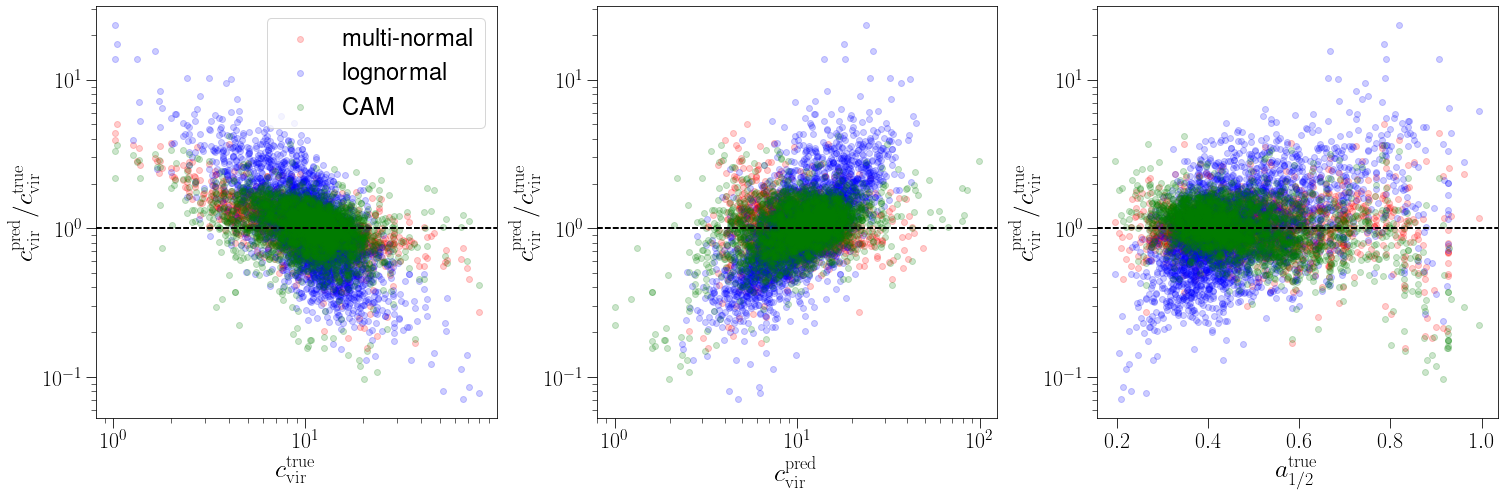

In [13]:
labels = ['multi-normal', 'lognormal', 'CAM']
colors = ['r', 'b', 'g']
scatter_plots(lam_test, cvir_test, gauss, lognormal, cam, labels=labels, colors=colors, alpha=0.2)

## Median bin statistic

In [14]:
def make_scatter_binning(ax, x, y, n_xbins=15, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    ax.errorbar(
        xmeds,
        ymeds,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

In [15]:
def median_bin_statistic(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        make_scatter_binning(ax1, X_test, x, color=colors[i], label=labels[i])
        ax1.set_xlabel(r"$c^{\rm true}_{\rm vir}$")
        ax1.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")
        

        make_scatter_binning(ax2, X_pred, x, color=colors[i], label=labels[i])
        ax2.set_xlabel(r"$c^{\rm pred}_{\rm vir}$")
        ax2.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")    
    
        make_scatter_binning(ax3, a_2_test, x, color=colors[i], label=labels[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")  
        
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

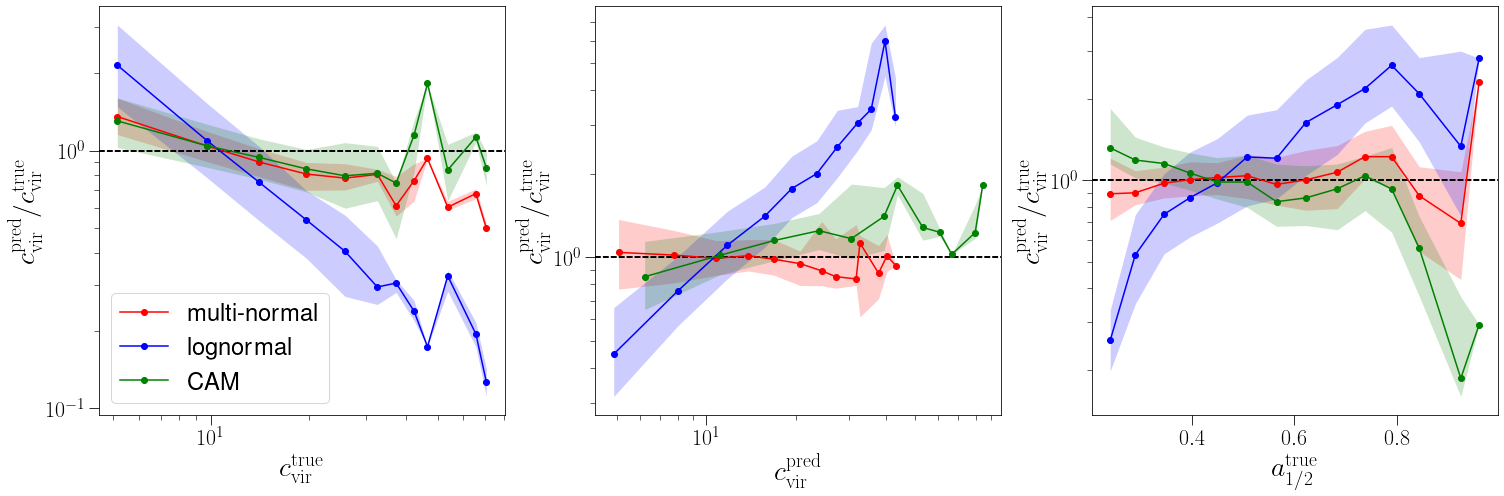

In [16]:
labels = ['multi-normal', 'lognormal', 'CAM']
colors = ['r', 'b', 'g']
median_bin_statistic(lam_test, cvir_test, gauss, lognormal, cam, labels=labels, colors=colors)